In [1]:
import numpy as np
from scipy import *
from pylab import *
import os

%matplotlib inline

In [21]:
folder_Pk = '/global/cscratch1/sd/jialiu/CAMELS/Pk/'
home = '/global/homes/j/jialiu/cosmo_dep_feedback/'

In [14]:
# for ifolder in ['IllustrisTNG',  'IllustrisTNG_DM',  'SIMBA',  'SIMBA_DM']:
#     for iz in [0.00, 1.05, 2.00]:       
#         print (ifolder, iz)
#         Pk_arr = array([np.loadtxt(folder_Pk+'%s/LH_%i/Pk_m_z=%.2f.txt'%(ifolder, i, iz)) for i in range(1000)])
#         save(folder_Pk+'%s_Pk_m_z=%.2f.npy'%(ifolder, iz), Pk_arr[:,:,1])
#         if ifolder=='IllustrisTNG' and iz==0:
#             k=Pk_arr[0,:,0]
#             save(home+'%s_k_m_z=%.2f.npy'%(ifolder, iz), Pk_arr[0,:,0])
#         elif sum(Pk_arr[0,:,0]-k):
#             print (ifolder, iz, 'k different')
#             save(home+'%s_k_m_z=%.2f.npy'%(ifolder, iz), Pk_arr[0,:,0])

IllustrisTNG 0.0
IllustrisTNG 1.05
IllustrisTNG 2.0
IllustrisTNG_DM 0.0
IllustrisTNG_DM 1.05
IllustrisTNG_DM 2.0
SIMBA 0.0
SIMBA 1.05
SIMBA 2.0
SIMBA_DM 0.0
SIMBA_DM 1.05
SIMBA_DM 2.0


In [25]:
ifolder = 'IllustrisTNG' ## 'SIMBA'
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')
Pk_TNG_0 = np.load(home+'Pk/%s_Pk_m_z=0.00.npy'%(ifolder))
Pk_TNGDM_0 = np.load(home+'Pk/%s_DM_Pk_m_z=0.00.npy'%(ifolder))
Pk_TNG_1 = np.load(home+'Pk/%s_Pk_m_z=1.05.npy'%(ifolder))
Pk_TNGDM_1 = np.load(home+'Pk/%s_DM_Pk_m_z=1.05.npy'%(ifolder))
Pk_TNG_2 = np.load(home+'Pk/%s_Pk_m_z=2.00.npy'%(ifolder))
Pk_TNGDM_2 = np.load(home+'Pk/%s_DM_Pk_m_z=2.00.npy'%(ifolder))

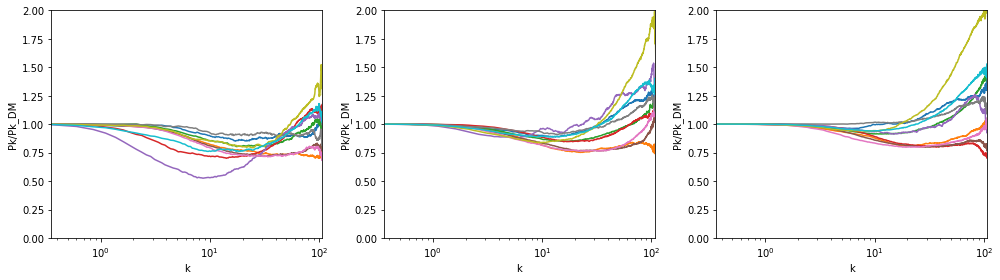

In [42]:
f, ax=subplots(1,3, figsize=(14,4))
for i in range(10):
    ax[0].plot(k, Pk_TNG_0[i]/Pk_TNGDM_0[i])
    ax[1].plot(k, Pk_TNG_1[i]/Pk_TNGDM_1[i])
    ax[2].plot(k, Pk_TNG_2[i]/Pk_TNGDM_2[i])

for j in range(3):
    ax[j].set_ylim(0, 2)
    ax[j].set_xlim(k[0], k[-20])
    ax[j].set_xscale('log')
    ax[j].set_xlabel('k')
    ax[j].set_ylabel('Pk/Pk_DM')
plt.tight_layout()
show()